# Projeto #1 - Regressão

<p style='text-align: justify;'><font size=3.>Análise de acidentes nas rodovias federais brasileira entre 2007 e 2021.</font></p>

### Bibliotecas básicas e outros imports

In [1]:
import random
import warnings
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

%run modules/text.py

%matplotlib inline
plt.rcParams['font.family'] = 'Arial, Helvetica, sans-serif'

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
np.set_printoptions(suppress=True, precision=3)

### Carregamento dos dados

In [2]:
df = pd.read_csv('dataset/regressor_acidentes_rodovias_brasileiras_2007_a_2021.csv', low_memory=False, encoding='utf-8')
print(f'Linhas: {df.shape[0]} | Coluna:  {df.shape[1]}')

Linhas: 1635078 | Coluna:  29


### Definição da variável resposta

In [3]:
df['classe'] = df['classificacao_acidente'].map({'com vitimas fatais': 'morto', 
                                                 'sem vitimas': 'sobrevivente',
                                                 'com vitimas feridas': 'sobrevivente'
                                                })
round(df['classe'].value_counts(normalize=True)*100, 2)

sobrevivente    96.01
morto            3.99
Name: classe, dtype: float64

### Geração de features

Período da semana

In [4]:
df['periodo_semana'] = df['dia_semana'].map(map_periodo_semana)

Causa presumível do acidente com base nas características

In [5]:
df['causa_presumivel_acidente'] = df['causa_acidente'].apply(mapCausaAcidentes)

Categorização do ano de fabricação do veículo com base na data do acidente

In [6]:
labels = ['ate dez anos', 'mais de dez anos']
classes = [0, 10, 170]

df['tempo_fabricacao_no_ano_do_acidente'] = df['ano'] - df['ano_fabricacao_veiculo']
df['faixa_ano_fabricacao'] = pd.cut(x=df['tempo_fabricacao_no_ano_do_acidente'], bins=classes, labels=labels, include_lowest=True)

Combinação das variáveis tipo de veículo e tipo de envolvido

> Identifica a forma como se deu a participação da vítima no acidente

In [7]:
df['condicao_envolvimento'] = df.apply(lambda x: mapCondicaoEnvolvimento(x.tipo_envolvido, x.porte_veiculo), axis=1)

Agrupamento dos tipos de acidentes

In [8]:
df['tipo_acidente_agrupado'] = df['tipo_acidente'].apply(mapTiposDeAcidentes)

### Seleção de features

In [9]:
colunas = [
    'sexo',
    'faixa_etaria',
    'condicao_envolvimento',
    'tipo_acidente_agrupado',
    'tipo_pista',
    'tracado_via',    
    'periodo_semana',
    'fase_dia',
    'uso_solo',
    'regiao_pais',
    'sentido_via', 
    'condicao_clima',
    'causa_presumivel_acidente',
    'faixa_ano_fabricacao',
    'classe'
]
dados = df[colunas]
dados.head(1)

,sexo,faixa_etaria,condicao_envolvimento,tipo_acidente_agrupado,tipo_pista,tracado_via,periodo_semana,fase_dia,uso_solo,regiao_pais,sentido_via,condicao_clima,causa_presumivel_acidente,faixa_ano_fabricacao,classe
0,masculino,jovem,ocupantes de automóveis,colisão,simples,reta,segunda a quinta-feira,plena noite,urbano,sul,decrescente,tempo ruim,aspectos relacionados ao comportamento do cond...,ate dez anos,sobrevivente


### Distribuição das variáveis explicativas

In [10]:
for col in dados.columns:
    print(round(dados[col].value_counts(normalize=True)*100, 2))
    print('---------------------------------')

masculino    88.46
feminino     11.54
Name: sexo, dtype: float64
---------------------------------
adulto         63.73
jovem          28.58
idoso           6.85
adolescente     0.47
criança         0.37
Name: faixa_etaria, dtype: float64
---------------------------------
ocupantes de automóveis              58.88
ocupantes de caminhão/ônibus         26.62
ocupantes de motocicleta/bicileta    14.07
pedestre                              0.43
outros veículos                       0.00
Name: condicao_envolvimento, dtype: float64
---------------------------------
colisão                   65.14
saída da pista            15.44
capotamento/tombamento     9.61
atropelamento              4.48
queda de veículo           3.35
outros                     1.99
Name: tipo_acidente_agrupado, dtype: float64
---------------------------------
simples     52.20
dupla       40.24
multipla     7.56
Name: tipo_pista, dtype: float64
---------------------------------
reta                     70.47
curva      

### Regressão logística binomial

> Para todos os testes será empregado o nível de confiança de 95%, ou seja, p-valor < 0.05 indica que os coeficientes estimados foram estatisticamente significativos

Removido os valores que, durante a rodada de testes para seleção do modelo final, tiveram um p-valor > 0.05

In [11]:
dados.drop(dados[dados['fase_dia'] == 'plena noite'].index, inplace=True)
dados.drop(dados[dados['condicao_envolvimento'] == 'outros veículos'].index, inplace=True)
dados.drop(dados[dados['faixa_etaria'] == 'criança'].index, inplace=True)
dados.drop(dados[dados['tracado_via'] == 'rotatoria'].index, inplace=True)
dados.drop(dados[dados['tracado_via'] == 'tunel'].index, inplace=True)
dados.drop(dados[dados['tracado_via'] == 'viaduto'].index, inplace=True)
dados.drop(dados[dados['regiao_pais'] == 'norte'].index, inplace=True)
dados.drop(dados[dados['tipo_acidente_agrupado'] == 'outros'].index, inplace=True)
dados.drop(dados[dados['tipo_pista'] == 'multipla'].index, inplace=True)
dados.drop(dados[dados['condicao_envolvimento'] == 'pedestre'].index, inplace=True)
print(f'Linhas: {dados.shape[0]} | Coluna:  {dados.shape[1]}')

Linhas: 962881 | Coluna:  15


Testando interação entre sexo e idade

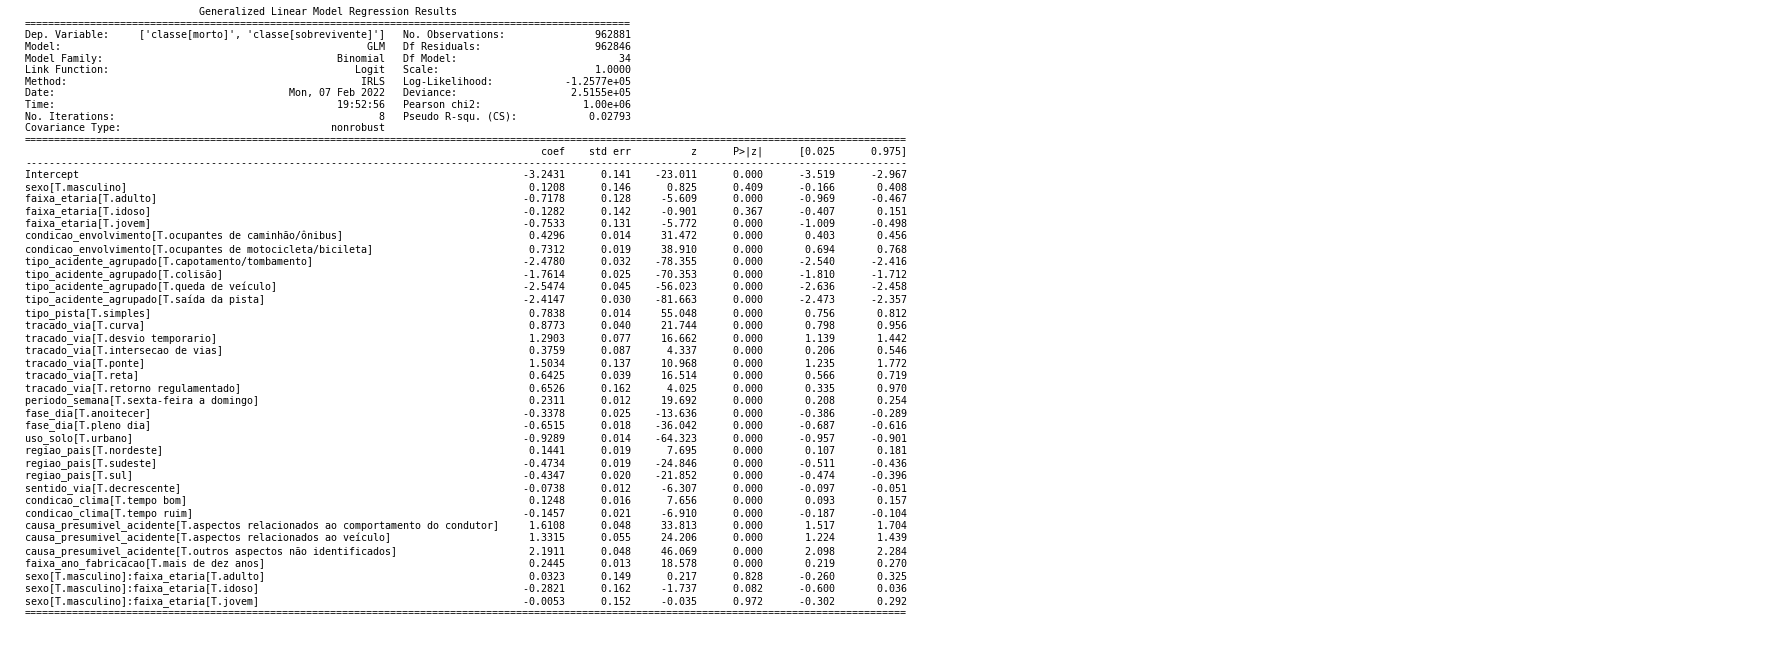

In [12]:
model = smf.glm(formula='classe ~ sexo+faixa_etaria+condicao_envolvimento+tipo_acidente_agrupado+tipo_pista+tracado_via+periodo_semana+fase_dia+uso_solo+regiao_pais+sentido_via+condicao_clima+causa_presumivel_acidente+faixa_ano_fabricacao+sexo*faixa_etaria', 
                 data=dados, family=sm.families.Binomial()).fit()


plt.rc('figure', figsize=(25, 10))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig('img/summary_model_logistic_regression_interaction_sex_age.png')

> <p style='text-align: justify;'><font size=2.85>O p-valor indica que não existe efeito de interação entre as variáveis sexo e idade.<font size=2.85></font></p>

Testando interação entre condição de envolvimento e sexo

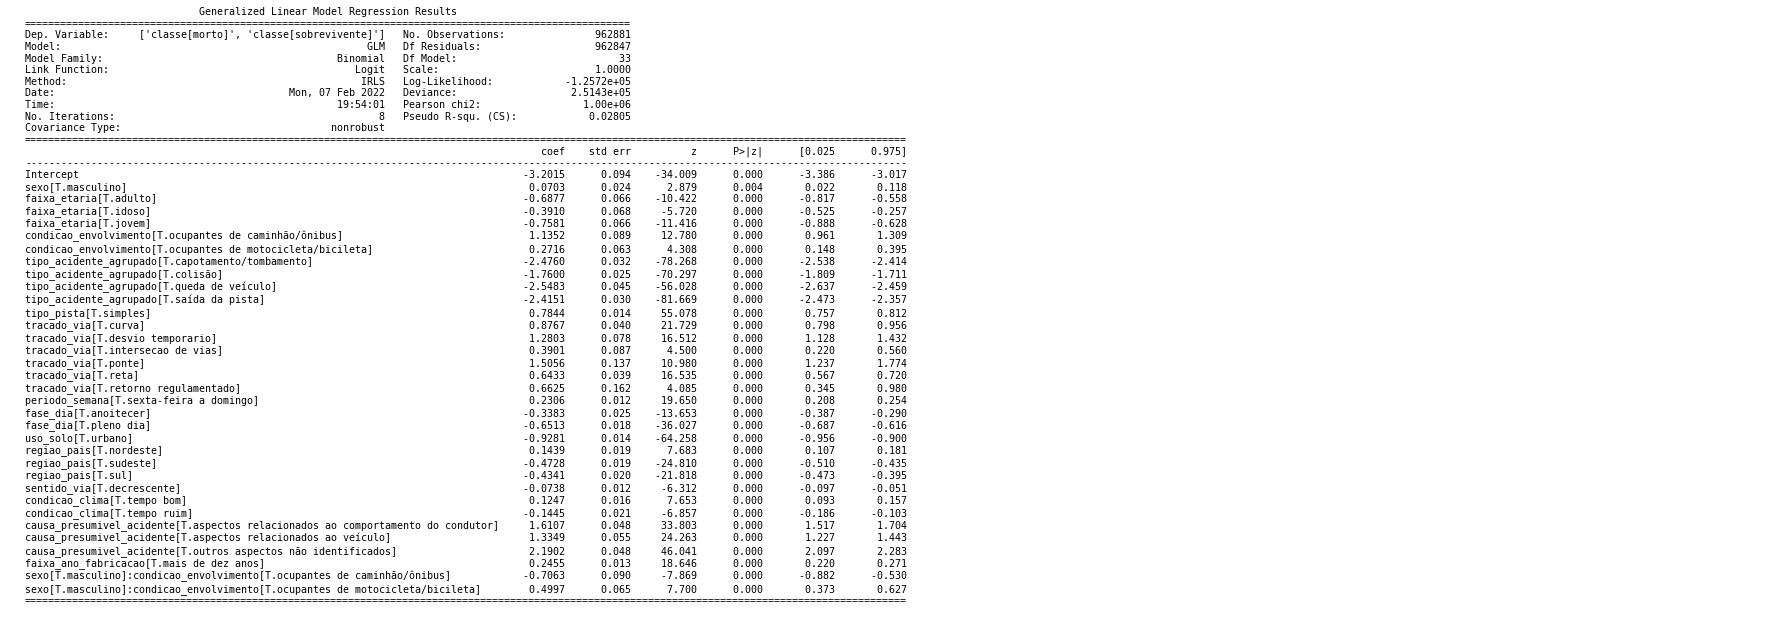

In [13]:
model = smf.glm(formula='classe ~ sexo+faixa_etaria+condicao_envolvimento+tipo_acidente_agrupado+tipo_pista+tracado_via+periodo_semana+fase_dia+uso_solo+regiao_pais+sentido_via+condicao_clima+causa_presumivel_acidente+faixa_ano_fabricacao+sexo*condicao_envolvimento', 
                 data=dados, family=sm.families.Binomial()).fit()


plt.rc('figure', figsize=(25, 10))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig('img/summary_model_logistic_regression_interaction_sexo_envolvimento.png')

> <p style='text-align: justify;'><font size=2.85>O p-valor indica que o efeito de interação entre as variáveis condição de envolvimento e sexo é estatisticamente significativo.</font></p>

Testando interação entre tipo de pista e tipo de acidente

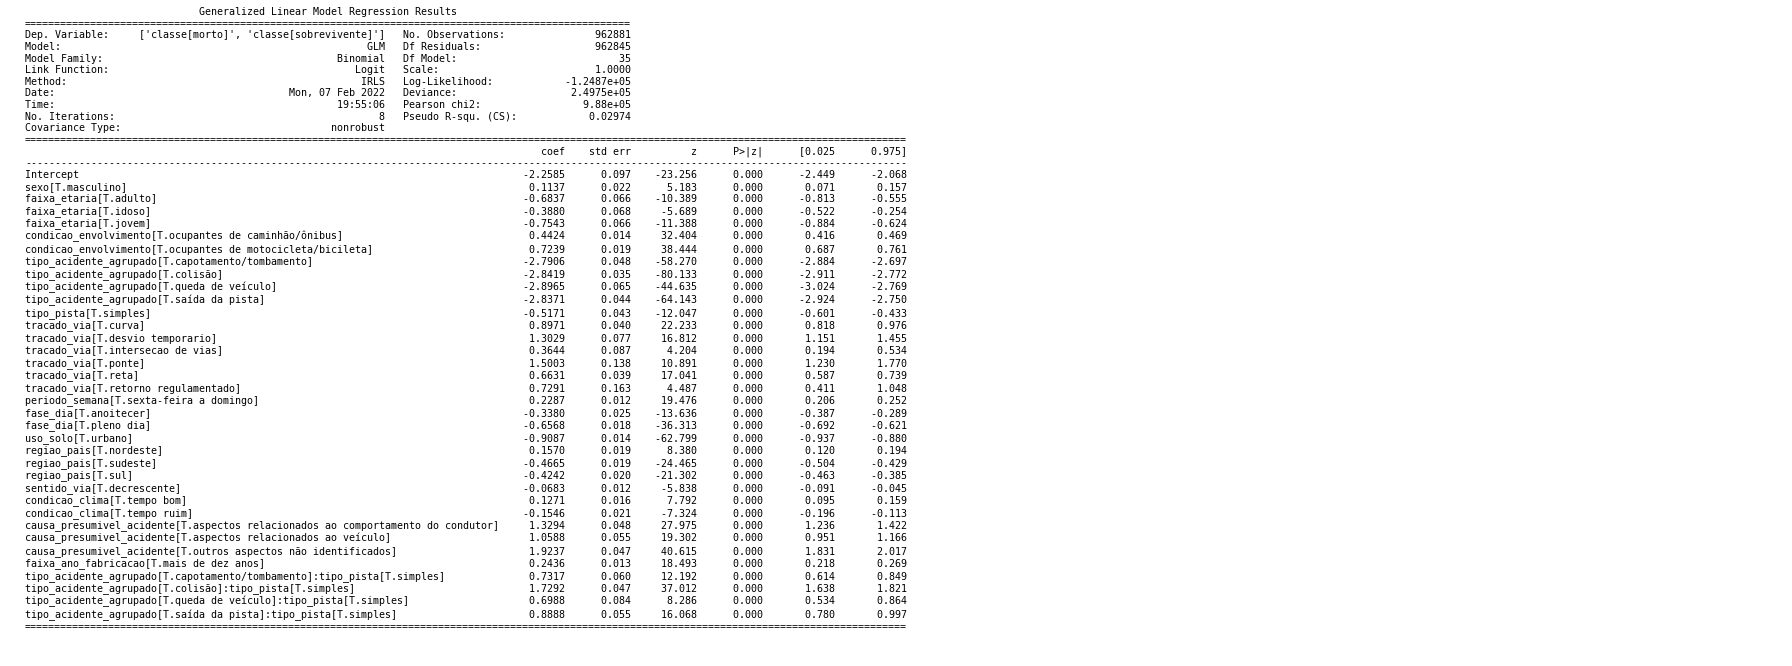

In [14]:
model = smf.glm(formula='classe ~ sexo+faixa_etaria+condicao_envolvimento+tipo_acidente_agrupado+tipo_pista+tracado_via+periodo_semana+fase_dia+uso_solo+regiao_pais+sentido_via+condicao_clima+causa_presumivel_acidente+faixa_ano_fabricacao+tipo_acidente_agrupado*tipo_pista', 
                 data=dados, family=sm.families.Binomial()).fit()


plt.rc('figure', figsize=(25, 10))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig('img/summary_model_logistic_regression_interaction_tipo_pista_acidente.png')

> <p style='text-align: justify;'>O p-valor indica que o efeito de interação entre as variáveis tipo de pista e tipo de acidente é estatisticamente significativo.<font size=2.85></font></p>

Modelo final

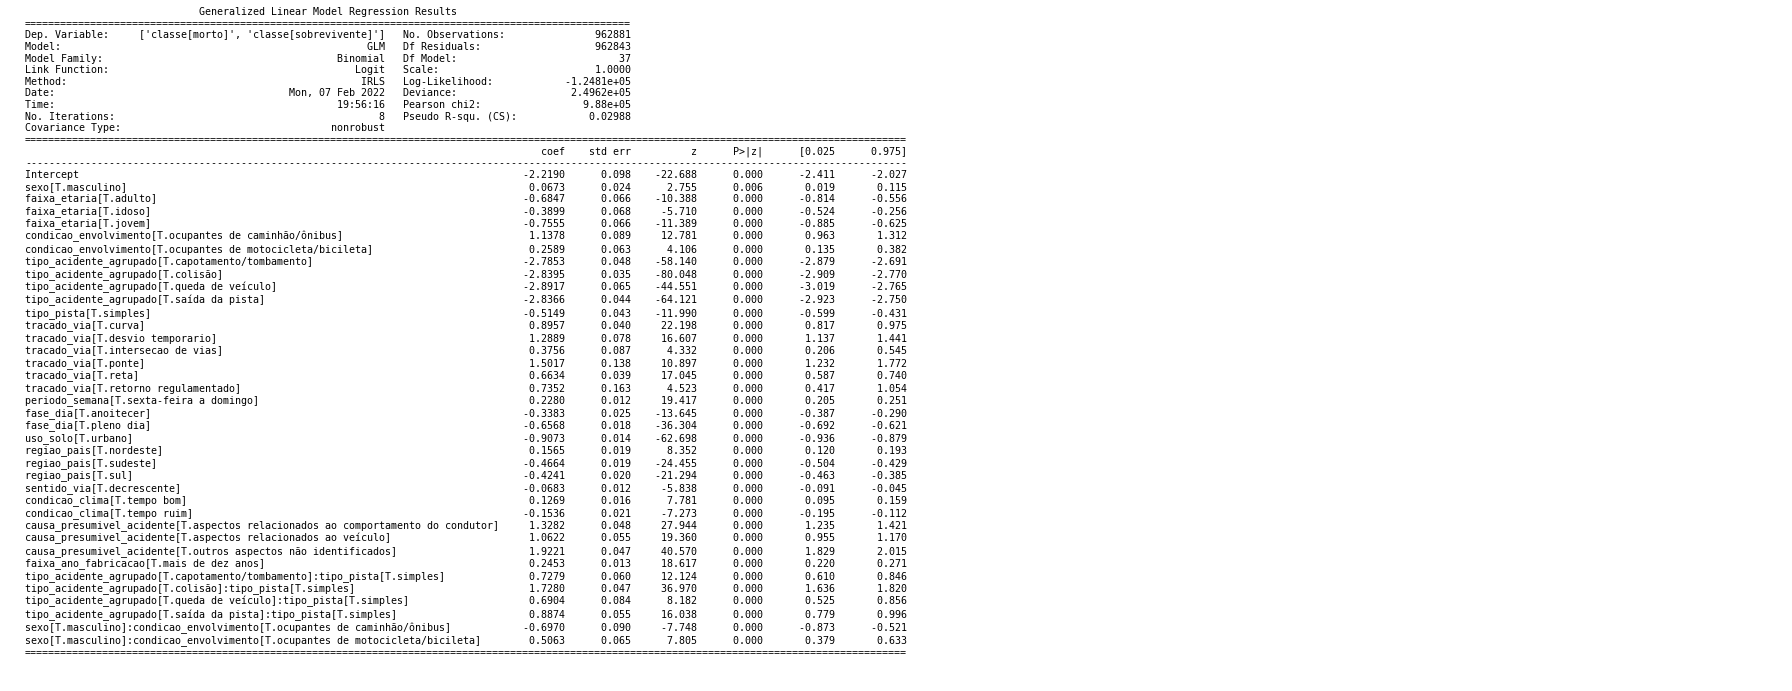

In [15]:
model = smf.glm(formula='classe ~ sexo+faixa_etaria+condicao_envolvimento+tipo_acidente_agrupado+tipo_pista+tracado_via+periodo_semana+fase_dia+uso_solo+regiao_pais+sentido_via+condicao_clima+causa_presumivel_acidente+faixa_ano_fabricacao+tipo_acidente_agrupado*tipo_pista+sexo*condicao_envolvimento', 
                 data=dados, family=sm.families.Binomial()).fit()

plt.rc('figure', figsize=(25, 10))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig('img/summary_model_logistic_regression.png')

Teste de bondade de ajuste de Hosmer e Lemeshow

Interpretação

In [17]:
# print((np.exp(model.params[1:]) - 1) * 100 )
#Pessoas com automóveis com mais de 10 anos de fabricação tem 20% mais chances de sobrevivência 
#do que pessoas com automóveis com até de 10 anos